In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os 
from mne.datasets.limo import load_data
from mne.stats import linear_regression
from mne.viz import plot_events, plot_compare_evokeds
from mne import combine_evoked
from mne.minimum_norm import apply_inverse, make_inverse_operator, get_point_spread, make_inverse_resolution_matrix

import warnings
warnings.filterwarnings('ignore')

print(__doc__)

Automatically created module for IPython interactive environment


## About the data

In the original LIMO experiment, participants performed a two-alternative forced choice task, discriminating between two face stimuli. The same two faces were used during the whole experiment, with varying levels of noise added, making the faces more or less discernible to the observer.

The presented faces varied across a noise-signal (or phase-coherence) continuum spanning from 0 to 85% in increasing steps of 5%. In other words, faces with high phase-coherence (e.g., 85%) were easy to identify, while faces with low phase-coherence (e.g., 5%) were hard to identify and by extension very hard to discriminate.


Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3153743/

## Load the data

Fetches epoched data files the LIMO dataset 1. If the LIMO files are not found on disk, the fetcher mne.datasets.limo.load_data() will automatically download the files from a remote repository.

In [3]:
limo_epochs = []
for subj in range(1,19):
    limo_epochs.append(load_data(subject=subj))

Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1055 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1052 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1072 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1050 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1118 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1108 matching ev

Note that the result of the loading process is an mne.EpochsArray containing the data ready to interface with MNE-Python.

In [6]:
print(limo_epochs[0])

<EpochsArray |  1055 events (all good), -0.299944 - 0.499907 sec, baseline off, ~213.7 MB, data loaded, with metadata,
 'Face/A': 524
 'Face/B': 531>


## Visualize events
We can visualise the distribution of the face events contained in the limo_epochs structure. Events should appear clearly grouped, as the epochs are ordered by condition.

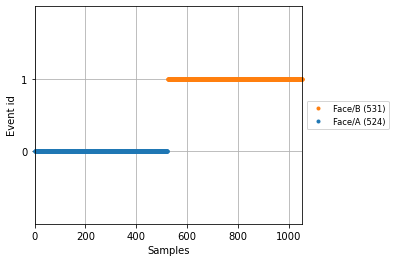

Text(0.5, 0.98, 'Distribution of events in LIMO epochs')

In [7]:
sbj2use = 0

fig = plot_events(limo_epochs[sbj2use].events, event_id=limo_epochs[sbj2use].event_id)
fig.suptitle("Distribution of events in LIMO epochs")

As it can be seen above, conditions are coded as Face/A and Face/B. Information about the phase-coherence of the presented faces is stored in the epochs metadata. These information can be easily accessed by calling limo_epochs.metadata. As shown below, the epochs metadata also contains information about the presented faces for convenience.

In [8]:
print(limo_epochs[sbj2use].metadata.head())


  face  phase-coherence
0    A         0.491210
1    A        -1.235572
2    A        -1.043707
3    A         1.642398
4    A        -0.659978


Now let’s take a closer look at the information in the epochs metadata.

In [10]:
# We want include all columns in the summary table
epochs_summary = limo_epochs[sbj2use].metadata.describe(include='all').round(3)
print(epochs_summary)

        face  phase-coherence
count   1055         1055.000
unique     2              NaN
top        B              NaN
freq     531              NaN
mean     NaN           -0.000
std      NaN            1.000
min      NaN           -1.619
25%      NaN           -0.852
50%      NaN           -0.084
75%      NaN            0.875
max      NaN            1.642


The first column of the summary table above provides more or less the same information as the print(limo_epochs) command we ran before. There are 1055 faces (i.e., epochs), subdivided in 2 conditions (i.e., Face A and Face B) and, for this particular subject, there are more epochs for the condition Face B.

In addition, we can see in the second column that the values for the phase-coherence variable range from -1.619 to 1.642. This is because the phase-coherence values are provided as a z-scored variable in the LIMO dataset. Note that they have a mean of zero and a standard deviation of 1.